In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot

In [2]:
train = pd.read_csv('../data/raw/application_train.csv')
test = pd.read_csv('../data/raw/application_test.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

# Домашнее задание №3

Задание выполняется на датасете Home credit на kaggle.
Вы можете использовать любую реализацию градиентного бустинга по вашему выбору: Lightgbm, Catboost ...
1. Взять три гиперпараметра для градиентного бустинга, и для каждого проварьировать один из них, фиксируя остальные. Построить графики зависимости метрики на кросс-валидации от параметра. Прокомментируйте, какие параметры и как влияют на переобучение.
2. Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров.
3. Построить график feature importance. Какие признаки оказались самыми важными?

Теперь переходим к стекингу.
Используем реализацию https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
1. Построить стекинг для 5 различных моделей по вашему выбору с разными параметрами. Можете взять любые, например 2 бустинга, 2 случайных леса, лог рег. Записать скор на тестовой выборке.
2. Теперь уберем из ансамбля наилучшую модель и снова постройте стекинг. Как изменился результат? Прокомментируйте.

## Градиентный бустинг

### Задание 1

In [3]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']
target = 'TARGET'

train_data = train.copy()
train_data[features] = train_data[features].fillna(0)

X, y = train_data[features], train_data[target]

10:	0.919271 (0.000001)
50:	0.919271 (0.000001)
100:	0.919268 (0.000006)
500:	0.919226 (0.000016)
1000:	0.919096 (0.000078)
5000:	0.916819 (0.000299)
10000:	0.912904 (0.000334)


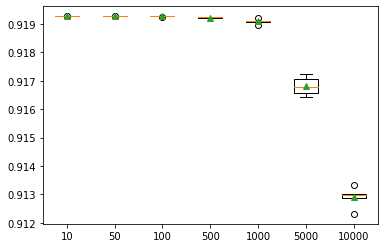

1:	0.919271 (0.000001)
2:	0.919271 (0.000001)
3:	0.919271 (0.000001)
4:	0.919271 (0.000001)
5:	0.919271 (0.000001)
6:	0.919274 (0.000007)
7:	0.919271 (0.000001)
8:	0.919265 (0.000022)
9:	0.919265 (0.000022)
10:	0.919232 (0.000035)
11:	0.919203 (0.000057)
12:	0.919174 (0.000054)
13:	0.919118 (0.000071)
14:	0.919063 (0.000112)


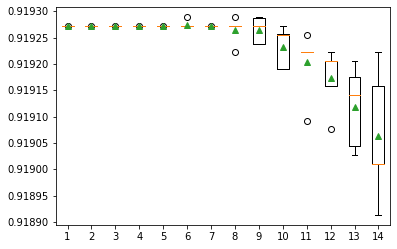

0.0001:	0.919271 (0.000001)
0.0010:	0.919271 (0.000001)
0.0100:	0.919271 (0.000001)
0.1000:	0.919268 (0.000006)
0.5000:	0.918767 (0.000108)
1.0000:	0.914777 (0.000397)


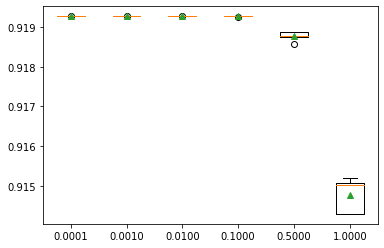

In [4]:
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='accuracy')
    return scores

def get_trees_count_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000, 5000, 10000]
    for n in trees:
        models[str(n)] = LGBMClassifier(n_estimators=n)
    return models

def get_tree_depth_models():
    models = dict()
    for i in range(1,15):
        models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
    return models

def get_learning_rate_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r)
    return models

# Trees count

models = get_trees_count_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, train_data[features], train_data[target])
    results.append(scores)
    names.append(name)
    print('%s:\t%.6f (%.6f)' % (name, mean(scores), std(scores)))
    
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Tree depth

models = get_tree_depth_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, train_data[features], train_data[target])
    results.append(scores)
    names.append(name)
    print('%s:\t%.6f (%.6f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Learning rate

models = get_learning_rate_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, train_data[features], train_data[target])
    results.append(scores)
    names.append(name)
    print('%s:\t%.6f (%.6f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Задание 2

In [5]:
parameters = { 'n_estimators': range (10, 51, 10),
               'max_depth': range (1,10, 2),
               'min_samples_leaf': range (1,8) }

clf = RandomForestClassifier()

In [6]:
grid = GridSearchCV(clf, parameters)
grid.fit(X, y)
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 20}

In [7]:
rnd = RandomizedSearchCV(clf, parameters)
rnd.fit(X, y)
rnd.best_params_

{'n_estimators': 20, 'min_samples_leaf': 1, 'max_depth': 5}

### Задание 3

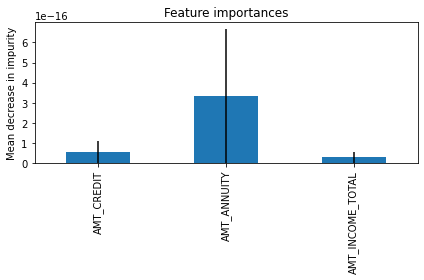

In [8]:
clf.fit(X, y)

std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
feature_importances = pd.Series(std, index=X.columns.values)

fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

По графику видно, что `AMT_ANNUITY`.

## Стекинг

### Задание 1

In [9]:
estimators = [
    ('rf1', RandomForestClassifier(n_estimators=10)),
    ('rf2', RandomForestClassifier(n_estimators=40, random_state=42)),
    ('b1', LGBMClassifier(n_estimators=50)),
    ('b2', LGBMClassifier(max_depth=5, num_leaves=2**5)),
    ('lr', LogisticRegression())
]

In [10]:
clf = StackingClassifier(estimators=estimators)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
score = clf.fit(X_train, y_train).score(X_test, y_test)
score

0.91928770259372

In [11]:
for estimator in estimators:
    scores = evaluate_model(estimator[1], train_data[features], train_data[target])
    print("Accuracy: %0.6f [%s]" % (scores.mean(), estimator[0]))

Accuracy: 0.904706 [rf1]
Accuracy: 0.905981 [rf2]
Accuracy: 0.919271 [b1]
Accuracy: 0.919271 [b2]
Accuracy: 0.919271 [lr]


### Задание 2

Убираем модель `LGBMClassifier(n_estimators=50)`

In [12]:
estimators = [
    ('rf1', RandomForestClassifier(n_estimators=10)),
    ('rf2', RandomForestClassifier(n_estimators=40, random_state=0)),
    ('b2', LGBMClassifier(max_depth=5, num_leaves=2**5)),
    ('lr', LogisticRegression())
]

clf = StackingClassifier(estimators=estimators)
score = clf.fit(X, y).score(X_test, y_test)
score

0.9193527407060538

По полученным результатам score практически не изменился.